# Install required package


In [33]:
!pip install kagglehub

import kagglehub
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Download dataset


In [34]:
path = kagglehub.dataset_download("ash2703/handsignimages")
print("✅ Dataset downloaded at:", path)
dataset_path = path
print("Dataset folders:", os.listdir(dataset_path))

Using Colab cache for faster access to the 'handsignimages' dataset.
✅ Dataset downloaded at: /kaggle/input/handsignimages
Dataset folders: ['Test', 'Train']


# Parameters

In [35]:
img_height, img_width = 40, 40
batch_size = 64

print(f"Image size: {img_height}×{img_width}")
print(f"Batch size: {batch_size}")

Image size: 40×40
Batch size: 64


#Augmentation

In [36]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
])

print("✅ Data augmentation created (optimized)")

✅ Data augmentation created (optimized)


# Load datasets

In [37]:
# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/Train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/Train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/Test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("\n📋 Classes:", class_names)
print(f"Number of classes: {len(class_names)}")

Found 27455 files belonging to 24 classes.
Using 21964 files for training.
Found 27455 files belonging to 24 classes.
Using 5491 files for validation.
Found 7172 files belonging to 24 classes.

📋 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Number of classes: 24


# Apply caching and prefetching for performance


In [38]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Data pipeline optimized")

✅ Data pipeline optimized


# Display sample augmented images


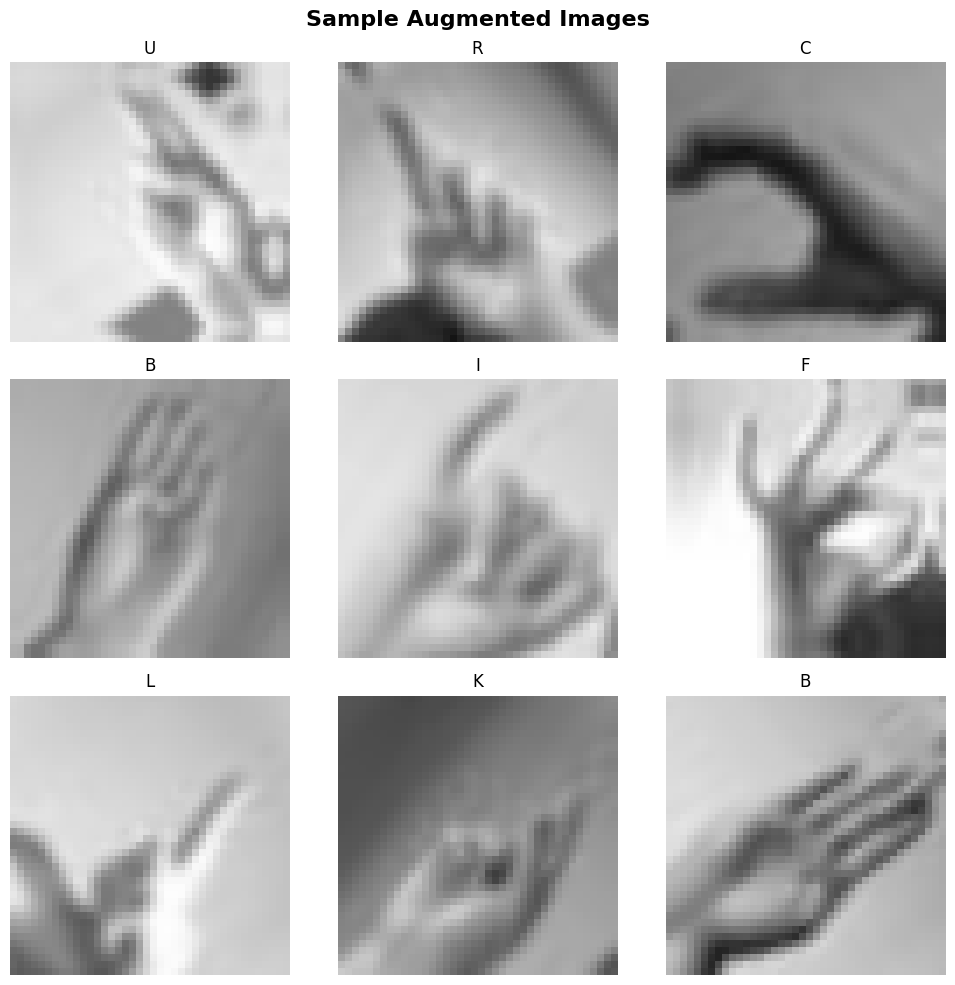

In [39]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Augmented Images", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Build model


In [40]:
model = tf.keras.models.Sequential([
    # Preprocessing
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,

    # Block 1: 40 filters (between 32 and 48)
    tf.keras.layers.Conv2D(40, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(40, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),

    # Block 2: 80 filters
    tf.keras.layers.Conv2D(80, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(80, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),

    # Block 3: 160 filters
    tf.keras.layers.Conv2D(160, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(160, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),

    # Fully connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(320, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print("✅ WORKING model architecture created")

✅ WORKING model architecture created


# Compile the model


In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled")

✅ Model compiled


# Build and display model architecture


In [42]:
model.build((None, img_height, img_width, 3))
print("\n📊 MODEL SUMMARY")
print("="*70)
model.summary()
print("="*70)


📊 MODEL SUMMARY


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 40, 40, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40, 40, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 40, 40, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 20, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20, 20, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 20, 20, 80)     │        57,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 20, 20, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 10, 160)    │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 10, 10, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 10, 10, 160)    │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 10, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 5, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 320)            │     1,280,32

 Total params: 1,738,304 (6.63 MB)

 Trainable params: 1,737,184 (6.63 MB)

 Non-trainable params: 1,120 (4.38 KB)

#Callbacks


In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_hand_sign_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("✅ Callbacks configured")

✅ Callbacks configured


# Train the model


In [44]:
print("\n🚀 STARTING TRAINING")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

print("\n✅ Training completed!")


🚀 STARTING TRAINING
Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0843 - loss: 3.4563
Epoch 1: val_accuracy improved from -inf to 0.07030, saving model to best_hand_sign_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.0844 - loss: 3.4548 - val_accuracy: 0.0703 - val_loss: 3.8379 - learning_rate: 0.0010
Epoch 2/10
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2751 - loss: 2.1798
Epoch 2: val_accuracy improved from 0.07030 to 0.36733, saving model to best_hand_sign_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.2753 - loss: 2.1787 - val_accuracy: 0.3673 - val_loss: 1.8633 - learning_rate: 0.0010
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4531 - loss: 1.5456
Epoch 3: val_accuracy improved from 0.36733 to 0.77654, saving model to best_hand_sign_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4532 - loss: 1.5453 - val_accuracy: 0.7765 - val_loss: 0.6086 - learning_rate: 0.

# Evaluate model performance

In [45]:
print("\n📊 EVALUATING ON TEST DATA")
print("="*70)

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

print("="*70)
print(f"\n✅ FINAL TEST ACCURACY: {test_acc*100:.2f}%")
print(f"✅ FINAL TEST LOSS: {test_loss:.4f}")
print("="*70)


📊 EVALUATING ON TEST DATA
113/113 - 7s - 61ms/step - accuracy: 0.9424 - loss: 0.1600

✅ FINAL TEST ACCURACY: 94.24%
✅ FINAL TEST LOSS: 0.1600


# Visualize training curves


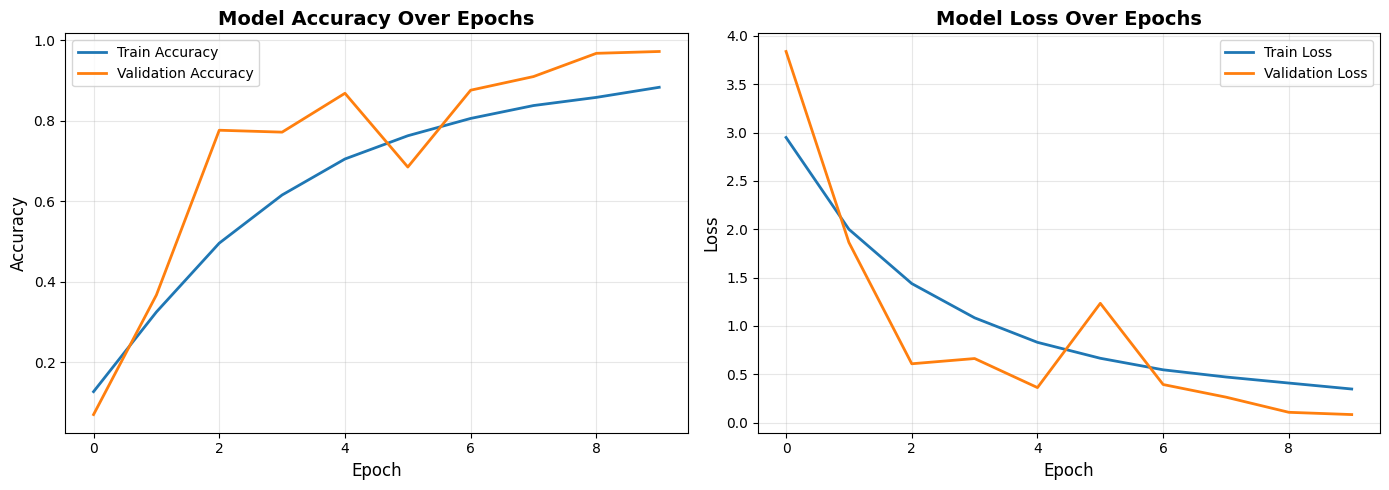

In [46]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save the final trained model


In [47]:
model.save('final_hand_sign_model.keras')
print("\n✅ Model saved as 'final_hand_sign_model.keras'")


✅ Model saved as 'final_hand_sign_model.keras'
